In [11]:
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle
from astropy.time import Time
from astropy.table import Table, unique

In [12]:
# Set up times and locations

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)
observing_time_start_birr = Time('2024-06-25 07:00:00', scale='utc', location=birr_loc)
observing_time_end_birr = Time('2024-06-26 14:00:00', scale='utc', location=birr_loc)
LST_start_birr = observing_time_start_birr.sidereal_time('mean')
LST_end_birr = observing_time_end_birr.sidereal_time('mean')

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)
observing_time_start_onsala = Time('2024-06-25 07:00:00', scale='utc', location=onsala_loc)
observing_time_end_onsala = Time('2024-06-26 14:00:00', scale='utc', location=onsala_loc)
LST_start_onsala = observing_time_start_onsala.sidereal_time('mean')
LST_end_onsala = observing_time_end_onsala.sidereal_time('mean')

# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon)/2
mid_loc = EarthLocation(lat=57.399*u.deg, lon=mid_lon)
observing_time_start_mid = Time('2024-06-25 07:00:00', scale='utc', location=mid_loc)
observing_time_end_mid = Time('2024-06-26 14:00:00', scale='utc', location=mid_loc)
LST_start_mid = observing_time_start_mid.sidereal_time('mean')
LST_end_mid = observing_time_end_mid.sidereal_time('mean')

print('Starting LST in Birr:', LST_start_birr)
print('Starting LST in Onsala:', LST_start_onsala)
print('Starting LST at midpoint:', LST_start_mid)

print('\n')

print('Ending LST in Birr:', LST_end_birr)
print('Ending LST in Onsala:', LST_end_onsala)
print('Ending LST at midpoint:', LST_end_mid)

Starting LST in Birr: 0h43m58.08020632s
Starting LST in Onsala: 2h03m22.56020631s
Starting LST at midpoint: 1h23m40.32020631s


Ending LST in Birr: 7h49m03.63149321s
Ending LST in Onsala: 9h08m28.1114932s
Ending LST at midpoint: 8h28m45.8714932s


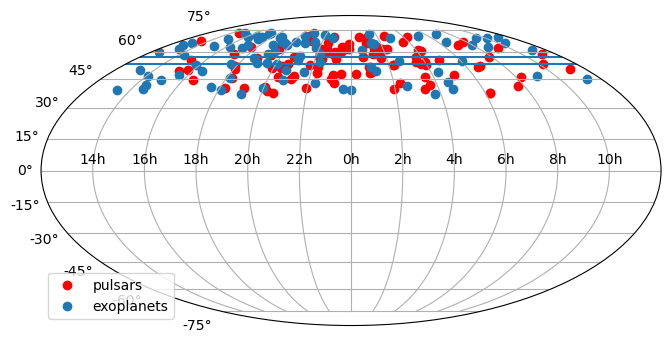

In [13]:
# import data and clean it up

# Exoplanet data
data = ascii.read('PS_2024.06.18_01.13.11.csv')
data.keep_columns(['hostname', 'ra', 'rastr', 'dec', 'decstr', 'sy_dist'])

# One planet per host
data = unique(data, 'hostname')

# Sort by distance
data.sort(keys='sy_dist')

# start and stop observing 40 minutes before/after zenith
start_obs = data['ra'] - 10
stop_obs = data['ra'] + 10

data['start_obs'] = start_obs
data['stop_obs'] = stop_obs

# Sky coordinates of the targets
coords = coord.SkyCoord(ra=data['ra']*u.deg, dec=data['dec']*u.deg)

# Get pulsar data
pulsars = ascii.read('pulsars.csv')
pulsars.remove_column('NUMBER')
pulsars.sort(keys='R_LUM')

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# Best to observe within 40 minutes of zenith
start_obs_psr = Angle(pulsars['RAJ'], u.hourangle).degree - 10

pulsars['start_obs'] = start_obs_psr

coords_psr = coord.SkyCoord(ra=pulsars['RAJ'], dec=pulsars['DECJ'], unit=(u.hourangle, u.deg))

# Plot them
ra = coord.Angle(data['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data['dec']*u.degree)

ra_psr = coords_psr.ra
ra_psr_wrapped = ra_psr.wrap_at(180*u.degree)
dec_psr = coords_psr.dec

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_psr_wrapped.radian, dec_psr.radian, label='pulsars', color='red')
ax.scatter(ra.radian, dec.radian, label='exoplanets')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()
ax.hlines(53*np.pi/180, -np.pi, np.pi)
ax.hlines(57*np.pi/180, -np.pi, np.pi)

In [68]:
# Find targets
data = unique(data, 'hostname')
data.sort(keys='sy_dist')

# Get the brighter pulsars only
bright_pulsar_ind = pulsars['R_LUM'] >= 1000
bright_pulsars = pulsars[bright_pulsar_ind]

coords_bright_psr = coord.SkyCoord(ra=bright_pulsars['RAJ'], dec=bright_pulsars['DECJ'], unit=(u.hourangle, u.deg))

bright_pulsars['RAJ'] = coords_bright_psr.ra
bright_pulsars['DECJ'] = coords_bright_psr.dec

bright_pulsars.sort(keys='R_LUM', reverse=True)

data_test = Table(data, copy=True)



# Haven't observed a pulsar yet
pulsar_observed = False


pointing_time_planet = ((1*u.hr + 20*u.min) + 1*u.min).to(u.hr).value
pointing_time_psr = ((20*u.min) + 1*u.min).to(u.hr).value

time = LST_start_mid.value
time_offset = - pointing_time_planet
time_offset_tracking = -pointing_time_planet
number_deleted = 0
target_list = []
target_type = []
newday_cutoff=0

obs_time = 31 # hours


# Go for obs_time hours
while time_offset_tracking <= obs_time + 1:
        
    # Move on 1 hr 21 mins (allow 1 minute to point) - done at start so it will fill in ending times as well
    time_offset += pointing_time_planet
    time_offset_tracking += pointing_time_planet

    # Check if the target reaches zenith between the start and end of the observation window
    if (time + time_offset) * 15 >= 360:
        time_offset -= 24
        newday_cutoff=len(target_list)-1

    # If we haven't observed a pulsar yet check if one is close to zenith and if so observe it, then move on - prioritises the earliest pulsar, not the brightest one
    if pulsar_observed == False:
        for i in range(len(bright_pulsars)):
            if ((time + time_offset) * 15) <= bright_pulsars['RAJ'][i] and bright_pulsars['RAJ'][i] <= ((time + time_offset + 81/60) * 15):
                target_list.append(bright_pulsars['NAME'][i])
                target_type.append('psr')

                # Do not observe any more pulsars
                pulsar_observed = True

                # Move on 16 mins (allow 1 minute to point)
                time_offset += pointing_time_psr
                time_offset_tracking += pointing_time_psr
                break

    # Check all stars to see if they approach zenith
    for i in range(len(data_test['ra']) - number_deleted):
        if ((time + time_offset) * 15) <= data_test['ra'][i] and data_test['ra'][i] <= ((time + time_offset + 81/60) * 15): 

            # Add to list of targets
            target_list.append(data_test['hostname'][i])
            target_type.append('planet')

            # Remove target from the list 
            data_test.remove_row(i)

            # Keep track of how many deleted to prevent going out of bounds
            number_deleted += 1
            break

# Output target list
print(target_list)



['TOI-2120', 'B0329+54', 'TOI-1634', 'TOI-1685', 'TOI-1694', 'TOI-1728', 'TOI-3785', 'TOI-1235', 'TOI-2068', 'TOI-1266', 'TOI-2076', 'TOI-1411', 'TOI-2081', 'TOI-1450 A', 'TOI-1680', 'GJ 806', 'TOI-2285', 'TOI-3629', 'TOI-1467', 'TOI-1736', 'TOI-1696', 'TOI-3757', 'HD 77946', 'TOI-1260']


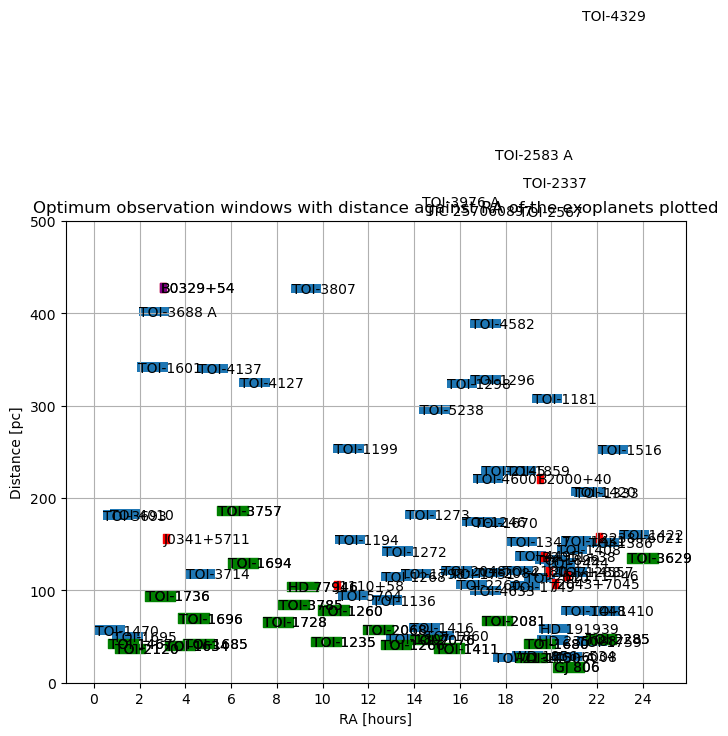

In [30]:
# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))

# All planets
for i in range(len(data['ra'])):
    # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(data['ra'][i] - 10, 20)], (data['sy_dist'][i], 10))
    ax.text(data['ra'][i]+0.5 - 10, data['sy_dist'][i], data['hostname'][i])

# Targeted planets
for i in range(len(target_list)):
    index = data['hostname'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
        ax.broken_barh([(data['ra'][ind] - 10, 20)], (data['sy_dist'][ind], 10), color='green')
        ax.text(data['ra'][ind]+0.5 - 10, data['sy_dist'][ind], data['hostname'][ind])

# All pulsars
for i in range(len(bright_pulsars['start_obs'])):
    # Plot from optimum start time of observation to +3.75 degrees (15 mins)
    ax.broken_barh([(bright_pulsars['start_obs'][i], 3.75)], (bright_pulsars['R_LUM'][i]/10, 10), color='red')
    ax.text(bright_pulsars['start_obs'][i]+0.5, bright_pulsars['R_LUM'][i]/10, bright_pulsars['NAME'][i])

# Targeted pulsar
for i in range(len(bright_pulsars['start_obs'])):
    index = bright_pulsars['NAME'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +3.75 degrees (15 mins)
        ax.broken_barh([(bright_pulsars['start_obs'][ind], 3.75)], (bright_pulsars['R_LUM'][ind]/10, 10), color='purple')
        ax.text(bright_pulsars['start_obs'][ind]+0.5, bright_pulsars['R_LUM'][ind]/10, bright_pulsars['NAME'][ind])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_ylim([0, 500])
ax.set_title('Optimum observation windows with distance against RA of the exoplanets plotted')

plt.show()

In [16]:
# Output schedule with pointings

sched = Table(names=('target', 'ra', 'dec'), dtype=(str, float, float))

time = observing_time_start_mid.mjd

start_times = np.array([])
end_times = np.array([])

for i in range(len(target_list)):
    if target_type[i] == 'planet':
        index = data['hostname'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        # Store times
        start_times = np.append(start_times, time)
        # Wait the 1 hr 21 minutes
        time += pointing_time_planet/24
        end_times = np.append(end_times, time - (1*u.min).to(u.day).value)

        sched.add_row((data['hostname'][ind], data['ra'][ind], data['dec'][ind]))
        
    elif target_type[i] =='psr':
        index = bright_pulsars['NAME'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        # Store times
        start_times = np.append(start_times, time)
        # Wait the 16 minutes
        time += pointing_time_psr/24
        end_times = np.append(end_times, time - (1*u.min).to(u.day).value)
        
        sched.add_row((bright_pulsars['NAME'][ind], bright_pulsars['RAJ'][ind], bright_pulsars['DECJ'][ind]))

# Add timings
sched['start_utc'] = Time(start_times, format='mjd').iso
sched['end_utc'] = Time(end_times, format='mjd').iso


In [17]:
sched

target,ra,dec,start_utc,end_utc
str10,float64,float64,str23,str23
TOI-2120,23.507315,65.5139877,2024-06-25 07:00:00.000,2024-06-25 08:20:00.000
B0329+54,53.24583333333332,54.578694444444444,2024-06-25 08:21:00.000,2024-06-25 08:41:00.000
TOI-1634,56.3906096,37.1122803,2024-06-25 08:42:00.000,2024-06-25 10:02:00.000
TOI-1685,68.5939529,43.0370395,2024-06-25 10:03:00.000,2024-06-25 11:23:00.000
TOI-1694,97.7487104,66.3605956,2024-06-25 11:24:00.000,2024-06-25 12:44:00.000
TOI-1728,120.6116787,64.7971531,2024-06-25 12:45:00.000,2024-06-25 14:05:00.000
TOI-3785,130.9002258,63.0780768,2024-06-25 14:06:00.000,2024-06-25 15:26:00.000
TOI-1235,152.2182549,69.2766204,2024-06-25 15:27:00.000,2024-06-25 16:47:00.000
TOI-2068,186.27356,60.4183455,2024-06-25 16:48:00.000,2024-06-25 18:08:00.000


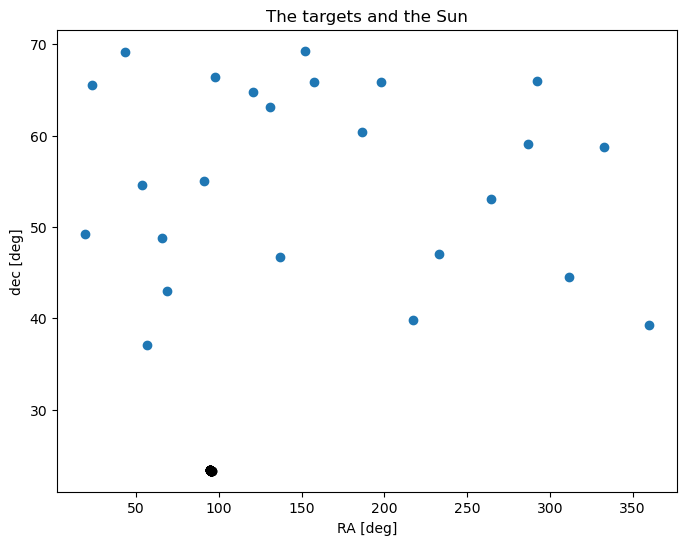

In [18]:
# Check if the targets approach the sun

middle_times = (start_times + end_times)/2

sun_times = Time(middle_times, format='mjd')

sun_loc = coord.get_sun(sun_times)

sun_ra = sun_loc.ra
sun_dec = sun_loc.dec

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(sun_ra, sun_dec, color='black')
ax.scatter(sched['ra'], sched['dec'])
ax.set_title('The targets and the Sun')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('dec [deg]')

dist_to_sun = np.array([])

for i in range(len(sched['ra'])):
    dist_to_sun = np.append(dist_to_sun, np.sqrt((sun_ra[i].value - sched['ra'][i])**2 + (sun_dec[i].value - sched['dec'][i])**2))
    if dist_to_sun[-1] <= 20:
        print(f'Warning, %s is within 20 degrees of the Sun' %sched['target'][i])

sched['angle_sun'] = dist_to_sun

In [19]:
ascii.write(sched, 'sched_out.csv', overwrite=True, delimiter=',')

Text(0.5, 1.0, 'schedualed time')

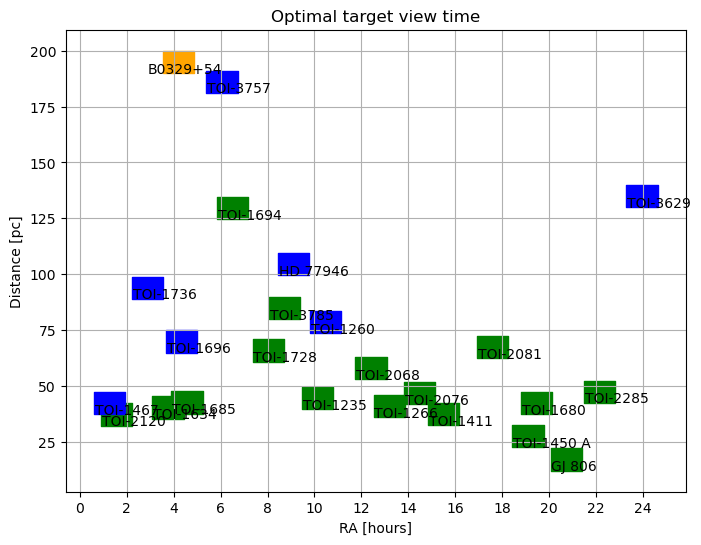

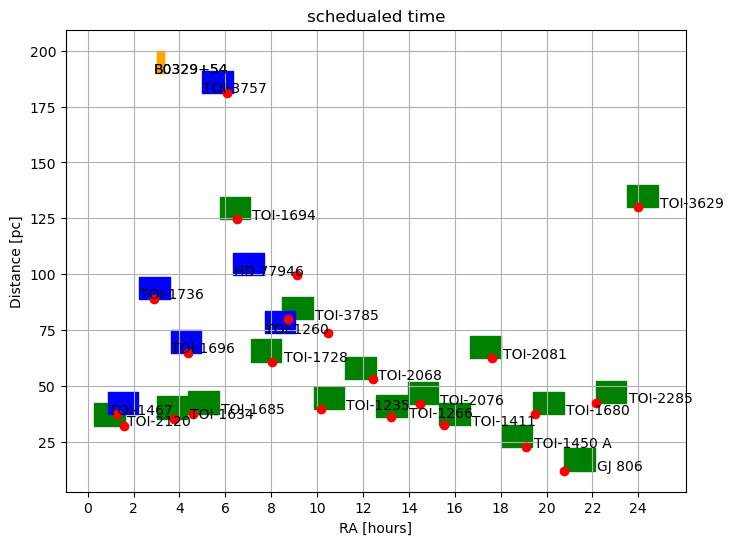

In [83]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

observation_time=pointing_time_planet
pulsar_obs=False  
pulsar_offset=0

#for i in range(len(data['ra'])):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
   # ax.broken_barh([(data['ra'][i] - 10, 20)], (data['sy_dist'][i], 10))
    #ax.text(data['ra'][i]+0.5 - 10, data['sy_dist'][i], data['hostname'][i])

width=observation_time*15*.5
for i in range(len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = data['hostname'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        #print(ind)
        #print(data[ind])
        # Plot from start time of observation to +20 degrees (1 hr 20 mins)
        if i<newday_cutoff:
            ax.broken_barh([(data['ra'][ind] - width, 20)], (data['sy_dist'][ind], 10), color='green')
            ax.text(data['ra'][ind]+0.5 - width, data['sy_dist'][ind], data['hostname'][ind])
        else: 
            ax.broken_barh([(data['ra'][ind] - width, 20)], (data['sy_dist'][ind], 10), color='blue')
            ax.text(data['ra'][ind]+0.5 - width, data['sy_dist'][ind], data['hostname'][ind])
    if target_type[i]=='psr':
        pulsar_obs=True
        ax.broken_barh([(53.24583333333332, 20)], (190, 10), color='orange')
        ax.text(53.24583333333332-width, 190, 'B0329+54')
ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimal target view time')


observing_times = np.array([])


for i in range(24):
   observing_times = np.append(observing_times, ((LST_start_mid.value + (81/60)*i) *15) % 360)

#ax.vlines(observing_times, 0, 700)
#ax.vlines(times, 0, 700)


fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
width=observation_time*15*.5
start_deg=time*360/24
break_deg=15/60  #1 minuit break

for i in range(len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)

    index = data['hostname'] == target_list[i]
    if target_type[i]=='planet':
        ind = np.argwhere(index)[0][0]
        if pulsar_obs==True:
            pulsar_offset=15/4
            i=i-1
        #print(ind)
        #print(data[ind])
        # Plot from start time of observation to +20 degrees (1 hr 20 mins)
        if i<newday_cutoff:
            ax.broken_barh([((observation_time)*i*15+start_deg+i*break_deg+pulsar_offset, 20)], (data['sy_dist'][ind], 10), color='green')
            ax.text(((observation_time)*i*15+start_deg+0.5)+start_deg+i*break_deg+pulsar_offset, data['sy_dist'][ind], data['hostname'][ind])
            ax.plot(data['ra'][ind],data['sy_dist'][ind],'ro')
            extra= (observation_time)*newday_cutoff*15+start_deg+newday_cutoff*break_deg-360
            #print(extra,newday_cutoff)
        else: 
            ax.broken_barh([((i-newday_cutoff)*(observation_time)*15+extra+(i-newday_cutoff)*break_deg+pulsar_offset, 20)], (data['sy_dist'][ind], 10), color='blue')
            ax.text(((i-newday_cutoff)*(observation_time)*15+0.5+extra+(i-newday_cutoff)*break_deg+pulsar_offset), data['sy_dist'][ind], data['hostname'][ind])
            ax.plot(data['ra'][ind],data['sy_dist'][ind],'ro')
    if target_type[i]=='psr':
        pulsar_obs=True
        ax.broken_barh([((observation_time)*i*15+start_deg+i*break_deg+pulsar_offset, 5)], (190, 10), color='orange')
        ax.text(53.24583333333332-10, 190, 'B0329+54')
        

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('schedualed time')

In [42]:
print(target_type)
print(target_list)

['planet', 'psr', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet', 'planet']
['TOI-2120', 'B0329+54', 'TOI-1634', 'TOI-1685', 'TOI-1694', 'TOI-1728', 'TOI-3785', 'TOI-1235', 'TOI-2068', 'TOI-1266', 'TOI-2076', 'TOI-1411', 'TOI-2081', 'TOI-1450 A', 'TOI-1680', 'GJ 806', 'TOI-2285', 'TOI-3629', 'TOI-1467', 'TOI-1736', 'TOI-1696', 'TOI-3757', 'HD 77946', 'TOI-1260']
